### Importar Bibliotecas

In [1]:
import os

import typing as tp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import models
import torchvision.transforms.v2 as transforms
from torchvision.io import read_image

from sklearn.model_selection import train_test_split

palette = "Set2"
sns.set(style="whitegrid", font_scale=0.8, palette=palette)

### Conectar com Drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

### Mapeamento de Classes (Dict Rótulo -> Valor)

In [3]:
classes_map = {
    0: "Nucleoplasm",
    1: "Nuclear membrane",
    2: "Nucleoli",
    3: "Nucleoli fibrillar center",
    4: "Nuclear speckles",
    5: "Nuclear bodies",
    6: "Endoplasmic reticulum",
    7: "Golgi apparatus",
    8: "Intermediate filaments",
    9: "Actin filaments",
    10: "Microtubules",
    11: "Mitotic spindle",
    12: "Centrosome",
    13: "Plasma membrane",
    14: "Mitochondria",
    15: "Aggresome",
    16: "Cytosol",
    17: "Vesicles and punctate cytosolic patterns",
    18: "Negative",
}

### Dataset Class

In [4]:
class HPADataset():
    '''
    A PyTorch Dataset for the Human Protein Atlas dataset.
    '''
    def __init__(
        self,
        images_dir: str,
        labels_csv: str,
        indices: tp.Optional[tp.List[int]] = None,
        transform: tp.Optional[transforms.Compose] = None,
    ):
        '''
        Initializes the HPADataset object.
        Parameters:
            images_dir: str
                The directory where the images are stored.
            labels_csv: str
                Path to the CSV file containing labels.
            indices: Optional[List[int]]
                Indices to use for this subset of the dataset.
            transform: Optional[transforms.Compose]
                If not None, the images will be transformed.
        '''
        # Salvar os argumentos
        self.images_dir = images_dir
        self.transform = transform

        # Listar todos os arquivos no diretório
        self.filenames = os.listdir(self.images_dir)

        # Remover a extensão dos arquivos
        self.filenames = [filename.split(".")[0] for filename in self.filenames]

        # Extrair a parte do nome do arquivo antes do primeiro "_"
        # self.filenames = [filename.split("_")[0] for filename in self.filenames]

        # Remover duplicatas
        # self.filenames = list(set(self.filenames))

        # Ordenar a lista de arquivos
        self.filenames.sort()

        # Carregar o arquivo CSV com os rótulos
        self.labels = pd.read_csv(labels_csv).set_index("ID")

        # Ordenar os rótulos de acordo com a ordem dos arquivos
        self.labels = self.labels.loc[self.filenames]

        # Converter a coluna 'Label' de strings para listas de inteiros
        self.labels['Label'] = self.labels['Label'].apply(lambda x: list(map(int, x.split('|'))))

        # Transformar os rótulos em binário
        self.binary_labels = torch.zeros((len(self.labels), 19), dtype=torch.float32)

        # Para cada rótulo, definir os índices correspondentes como 1
        for i, label_list in enumerate(self.labels['Label']):
            for label in label_list:
                self.binary_labels[i, label] = 1

        # Se índices são fornecidos, selecionar apenas esses índices
        if indices is not None:
            self.filenames = [self.filenames[i] for i in indices]
            self.binary_labels = self.binary_labels[indices]

    def __len__(self) -> int:
        '''
        Returns the number of images in the dataset.
        Returns:
            int
                The number of images in the dataset.
        '''
        return len(self.filenames)

    def __getitem__(self, idx) -> tp.Tuple[torch.Tensor, torch.Tensor]:
        '''
        Returns the image and its label.
        Parameters:
            idx: int
                The index of the image to be returned.
        Returns:
            Tuple[torch.Tensor, torch.Tensor]
                A tuple containing the image and its label.
        '''
        # Checar se o índice é válido
        if idx >= self.__len__():
            raise IndexError

        # Pegar todas a imagens
        # colors = ["_green", "_blue", "_red", "_yellow"]
        # images = [read_image(os.path.join(self.images_dir, self.filenames[idx] + color + ".png")) for color in colors]
        # image = torch.cat(images, 0)

        # Pegar imagem
        image = read_image(os.path.join(self.images_dir, self.filenames[idx]) + ".png")
        
        # Aplicar transformações
        if self.transform:
            image = self.transform(image)

        # Pegar os rótulos
        label = self.binary_labels[idx]

        return image, label

    def set_transform(self, transform: tp.Optional[transforms.Compose]) -> None:
        '''
        Sets the transform attribute.
        Parameters:
            transform: Optional[transforms.Compose]
                The transform to be set.
        '''
        self.transform = transform

### Função: Divisão Treino e Validação - Estratificação Multirótulo

In [5]:
def train_valid_split_multilabel(
    dataset_dir: str,
    labels_csv: str,
    train_transform: tp.Optional[transforms.Compose] = None,
    valid_transform: tp.Optional[transforms.Compose] = None,
    test_size=0.25
):
    '''
    Splits the dataset into training and validation sets.
    Parameters:
        dataset_dir: str
            The directory where the images are stored.
        labels_csv: str
            Path to the CSV file containing labels.
        train_transform: Optional[transforms.Compose]
            If not None, the images in the training set will be transformed.
        valid_transform: Optional[transforms.Compose]
            If not None, the images in the validation set will be transformed.
        test_size: float
            The proportion of the dataset to include in the validation set.
    '''

    # Carregar o dataset completo
    dataset = HPADataset(images_dir=dataset_dir, labels_csv=labels_csv)
    dataset_size = len(dataset)

    # Obter os índices de todas as amostras
    indices = list(range(dataset_size))

    # Criar uma matriz binária para representar a presença de cada rótulo em cada amostra
    binary_labels = np.zeros((dataset_size, len(classes_map)))

    for i, labels in enumerate(dataset.labels.values.flatten()):
        binary_labels[i, labels] = 1

    # Agora usar esta matriz binária para estratificação
    train_indices, valid_indices = train_test_split(
        indices,
        test_size=test_size,
        stratify=binary_labels.sum(axis=1), # Estratificar baseado no número de rótulos por amostra
        random_state=78
    )

    train_dataset = HPADataset(
        images_dir=dataset_dir,
        labels_csv=labels_csv,
        indices=train_indices,
        transform=train_transform)

    valid_dataset = HPADataset(
        images_dir=dataset_dir,
        labels_csv=labels_csv,
        indices=valid_indices,
        transform=valid_transform)
    
    # Calcular os pesos das classes
    total_count = train_dataset.binary_labels.sum()
    class_weights = total_count / (len(classes_map) * train_dataset.binary_labels.sum(axis=0))

    return train_dataset, valid_dataset, class_weights

### Função: Transformações de Treino e Validação

In [6]:
# Como fazer a normalização dos dados?
# Normalizar por uma métrica global ou por amostra?
# Sendo uma métrica global, calcular a média e o desvio padrão de todas as amostras
# Sendo por amostra, calcular a média e o desvio padrão de cada amostra

# Função para calcular a média e desvio padrão por canal
def get_mean_std(loader):
    mean = 0.0
    std = 0.0
    nb_samples = 0

    for data, _ in loader:
        batch_samples = data.size(0)  # Número de imagens no batch
        data = data.view(batch_samples, data.size(1), -1)  # (batch, canais, width * height)
        mean += data.mean(2).sum(0)  # Média por canal
        std += data.std(2).sum(0)    # Desvio padrão por canal
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    return mean, std

# mean: tensor([0.0807, 0.0804, 0.0538, 0.0522]) std: tensor([0.1233, 0.1273, 0.1422, 0.0818])

def train_transformations() -> transforms.Compose:
    '''
    Returns a composition of transformations to be applied to the training images.
    Returns:
        transforms.Compose
            The composition of transformations.
    '''
    return transforms.Compose([
        transforms.ToImage(), # Transformar de tensor para imagem
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.0807, 0.0804, 0.0538, 0.0522], std=[0.1233, 0.1273, 0.1422, 0.0818])
    ])


def valid_transformations() -> transforms.Compose:
    '''
    Returns a composition of transformations to be applied to the validation images.
    Returns:
        transforms.Compose
            The composition of transformations.
    '''
    return transforms.Compose([
        transforms.ToImage(), # Transformar de tensor para imagem
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.0807, 0.0804, 0.0538, 0.0522], std=[0.1233, 0.1273, 0.1422, 0.0818])
    ])

### Definição do Modelo

In [7]:
def HPA_EfficientNet_B0_Model():
    '''
    Builds a model for the Human Protein Atlas dataset using EfficientNet-B0.
    '''

    # Carregar o modelo EfficientNet-B0 pré-treinado
    model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

    # Obter a primeira camada convolucional
    first_conv_layer = model.features[0][0]

    # Criar uma nova camada convolucional com 4 canais de entrada, mantendo os outros parâmetros
    new_conv_layer = nn.Conv2d(
        in_channels=4,  # Mudar para 4 canais de entrada
        out_channels=first_conv_layer.out_channels,
        kernel_size=first_conv_layer.kernel_size,
        stride=first_conv_layer.stride,
        padding=first_conv_layer.padding,
        bias=first_conv_layer.bias is not None
    )

    # Copiar os pesos dos 3 primeiros canais da camada original para a nova camada
    with torch.no_grad():
        new_conv_layer.weight[:, :3, :, :] = first_conv_layer.weight

        # Inicializar os pesos do quarto canal com a média dos pesos dos três primeiros canais
        new_conv_layer.weight[:, 3, :, :] = first_conv_layer.weight.mean(dim=1)

    # Substituir a camada original pela nova
    model.features[0][0] = new_conv_layer

    # Modificar a última camada para classificação multirrótulo
    num_labels = 19
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_labels)

    # Aplicar a função sigmoid na saída para multirrótulo
    model.add_module('sigmoid', torch.nn.Sigmoid())

    return model

In [8]:
class SqueezeNetCAM(nn.Module):
    def __init__(self, num_classes=19):
        super(SqueezeNetCAM, self).__init__()
        # Carregar o modelo SqueezeNet pré-treinado
        self.squeezenet = models.squeezenet1_1(weights='SqueezeNet1_1_Weights.IMAGENET1K_V1')

        # Obter os pesos da camada original com 3 canais
        original_conv1_weights = self.squeezenet.features[0].weight.data

        # Modificar a primeira camada convolucional para aceitar 4 canais em vez de 3
        self.squeezenet.features[0] = nn.Conv2d(4, 64, kernel_size=3, stride=2, padding=1)

        # Inicializar a nova camada com os pesos da camada original
        with torch.no_grad():
            # Copiar os pesos dos 3 canais pré-treinados e repetir/adaptar para o 4º canal
            self.squeezenet.features[0].weight[:, :3, :, :] = original_conv1_weights
            self.squeezenet.features[0].weight[:, 3, :, :] = torch.mean(original_conv1_weights, dim=1)

        # Remover a camada de classificação original e substituir por uma nova para 19 classes
        self.squeezenet.classifier = nn.Conv2d(512, num_classes, kernel_size=1)

        # Camada de pool adaptativa para combinar com o CAM
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        # Extrair features da última camada convolucional
        features = self.squeezenet.features(x)

        # Aplicar a camada de classificação para obter os mapas de ativação
        output = self.squeezenet.classifier(features)

        # Aplicar global average pooling para transformar o output em [batch_size, num_classes]
        pooled_output = self.global_avg_pool(output)
        pooled_output = pooled_output.view(pooled_output.size(0), -1)

        return output, features, pooled_output


In [9]:
def generate_multilabel_cam(feature_map, class_weights, class_indices):
    # Inicializa o CAM com zeros para a forma espacial do feature_map
    cam = torch.zeros(feature_map.shape[2:], dtype=torch.float32)
    
    # Para cada classe predita (ou relevante), combina os pesos e o feature_map
    for class_idx in class_indices:
        for i, w in enumerate(class_weights[class_idx]):
            cam += w * feature_map[i, :, :]
    return cam

# Supondo que você já tem a saída do modelo e os mapas de ativação
# output, feature_map = model(input_image)

# Para multiclasse, obter as classes com alta confiança
# predicted_classes = torch.where(output > 0.5)[1]  # Pega as classes com probabilidade > 0.5

# Geração do CAM para as classes preditas
# cam = generate_multilabel_cam(feature_map[0].detach(), model.squeezenet.classifier.weight, predicted_classes)


### Função: Carregar e Salvar Checkpoints

In [10]:
def save_checkpoint(
    epoch: int,
    model: nn.Module,
    optimizer: optim.Optimizer,
    train_losses: tp.List[float],
    valid_losses: tp.List[float],
    filename: str = "checkpoint.pth"
):
    '''
    Salva um checkpoint do modelo, otimizador e outras informações úteis.
    Parâmetros:
        epoch: int - Número da época atual
        model: nn.Module - Modelo a ser salvo
        optimizer: optim.Optimizer - Otimizador a ser salvo
        train_losses: List[float] - Lista de loss no treinamento
        valid_losses: List[float] - Lista de loss na validação
        filename: str - Nome do arquivo para salvar o checkpoint
    '''
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'valid_losses': valid_losses
    }
    torch.save(checkpoint, filename)


def load_checkpoint(
    model: nn.Module,
    optimizer: optim.Optimizer,
    filename: str = "checkpoint.pth"
):
    '''
    Carrega um checkpoint do modelo e otimizador.
    Parâmetros:
        model: nn.Module - Modelo a ser carregado
        optimizer: optim.Optimizer - Otimizador a ser carregado
        filename: str - Nome do arquivo para carregar o checkpoint
    Retorna:
        epoch: int - Número da última época treinada
        train_losses: List[float] - Lista de loss no treinamento
        valid_losses: List[float] - Lista de loss na validação
    '''
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    valid_losses = checkpoint['valid_losses']
    return epoch, train_losses, valid_losses

### Função: Treinamento do Modelo [EfficientNet]

In [11]:
from tqdm import tqdm  # Importar tqdm para a barra de progresso

def train_model(
    train_loader: torch.utils.data.DataLoader,
    valid_loader: torch.utils.data.DataLoader,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    model: nn.Module,
    num_epochs: int,
    checkpoint: str,
    resume_checkpoint: tp.Optional[str] = None
):
    '''
    Função para treinar um modelo de classificação de imagens.
    Parâmetros:
        train_loader: torch.utils.data.DataLoader - Carregador de dados de treinamento
        valid_loader: torch.utils.data.DataLoader - Carregador de dados de validação
        optimizer: optim.Optimizer - Otimizador para treinar o modelo
        criterion: nn.Module - Função de loss para otimizar
        model: nn.Module - Modelo a ser treinado
        num_epochs: int - Número de épocas para treinar o modelo
        checkpoint: str - Caminho para salvar o checkpoint
        resume_checkpoint: str - Caminho para o checkpoint para retomar o treinamento
    '''

    # Definir dispositivo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Inicializar variáveis de loss e epoch
    train_losses = []
    valid_losses = []
    start_epoch = 0

    # Se for fornecido um checkpoint, carregar os pesos e o otimizador
    if resume_checkpoint:
        start_epoch, train_losses, valid_losses = load_checkpoint(model, optimizer, resume_checkpoint)

    # Loop de treinamento
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        # Adicionar a barra de progresso para os batches no treinamento
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zerar os gradientes
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # Propagar o erro
            optimizer.step()  # Atualizar os pesos
            running_loss += loss.item()

            # Atualizar a barra de progresso com a loss do batch atual
            progress_bar.set_postfix({'Train Loss': running_loss / len(progress_bar)})

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Salvar checkpoint após cada época
        save_checkpoint(epoch, model, optimizer, train_losses, valid_losses, checkpoint)

        # Loop de validação
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            progress_bar = tqdm(valid_loader, desc='Validation', unit='batch')
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                # Atualizar a barra de progresso com a loss da validação
                progress_bar.set_postfix({'Valid Loss': running_loss / len(progress_bar)})

            valid_loss = running_loss / len(valid_loader)
            valid_losses.append(valid_loss)

        torch.cuda.empty_cache()  # Limpar memória de GPU

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f}")


### Função: Treinamento do Modelo [SqueezeNet]

In [14]:
def train_squeeze_cam(
    train_loader: torch.utils.data.DataLoader,
    valid_loader: torch.utils.data.DataLoader,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    model: nn.Module,
    num_epochs: int,
    checkpoint: str,
    weight_update: int,  # Número de batches para acumular gradientes antes de atualizar os pesos
    resume_checkpoint: tp.Optional[str] = None
):
    '''
    Função para treinar um modelo de classificação de imagens.
    Parâmetros:
        train_loader: torch.utils.data.DataLoader - Carregador de dados de treinamento
        valid_loader: torch.utils.data.DataLoader - Carregador de dados de validação
        optimizer: optim.Optimizer - Otimizador para treinar o modelo
        criterion: nn.Module - Função de loss para otimizar
        model: nn.Module - Modelo a ser treinado
        num_epochs: int - Número de épocas para treinar o modelo
        checkpoint: str - Caminho para salvar o checkpoint
        weight_update: int - Número de batches para acumular gradientes antes de atualizar os pesos
        resume_checkpoint: str - Caminho para o checkpoint para retomar o treinamento
    '''

    # Definir dispositivo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Inicializar variáveis de loss e epoch
    train_losses = []
    valid_losses = []
    start_epoch = 0

    # Se for fornecido um checkpoint, carregar os pesos e o otimizador
    if resume_checkpoint:
        start_epoch, train_losses, valid_losses = load_checkpoint(model, optimizer, resume_checkpoint)

    # Loop de treinamento
    for epoch in range(start_epoch, num_epochs):

        # Modo de treinamento
        model.train()

        # Zerar os gradientes antes do início do treino e inicializar a loss
        optimizer.zero_grad()  
        running_loss = 0.0

        # Adicionar a barra de progresso para os batches no treinamento
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

        # Loop de treinamento
        for batch_idx, (inputs, labels) in enumerate(progress_bar):
            # Mover os dados para a GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            _, _, outputs = model(inputs)    

            # Calcular a loss
            loss = criterion(outputs, labels)

            # Acumular gradientes
            loss.backward()

            # Atualizar a loss total
            running_loss += loss.item()

            # Atualizar a barra de progresso com a loss do batch atual
            progress_bar.set_postfix({'Train Loss': running_loss / (batch_idx + 1)})

            # Atualizar os pesos após 'weight_update' batches
            if (batch_idx + 1) % weight_update == 0 or (batch_idx + 1) == len(train_loader):
                optimizer.step()  # Atualizar os pesos
                optimizer.zero_grad()  # Zerar os gradientes acumulados

        # Calcular a loss média do treinamento
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Salvar checkpoint após cada época
        save_checkpoint(epoch, model, optimizer, train_losses, valid_losses, checkpoint)

        # Loop de validação
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            progress_bar = tqdm(valid_loader, desc='Validation', unit='batch')
            for batch_idx, (inputs, labels) in enumerate(progress_bar):
                inputs, labels = inputs.to(device), labels.to(device)
                _, _, outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                # Atualizar a barra de progresso com a loss da validação
                progress_bar.set_postfix({'Valid Loss': running_loss / (batch_idx + 1)})

            valid_loss = running_loss / len(valid_loader)
            valid_losses.append(valid_loss)

        torch.cuda.empty_cache()  # Limpar memória de GPU

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f}")


### Carregar Modelo

In [15]:
# Instanciar o modelo
# model = HPA_EfficientNet_B0_Model()
model = SqueezeNetCAM(num_classes=19)

### Carregar Dados

In [19]:
dataset_dir = '/mnt/ssd/hpa-single-cell-image-classification/join_resized_train'
labels_csv = '/mnt/ssd/hpa-single-cell-image-classification/train.csv'

# Carregar os dados
train, valid, class_weights = train_valid_split_multilabel(
    dataset_dir=dataset_dir,
    labels_csv=labels_csv,
    train_transform=train_transformations(),
    valid_transform=valid_transformations(),
    test_size=0.20,
)

# Loaders
batch_size = 16

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)


In [ ]:
# mean, std = get_mean_std(train_loader)

In [21]:
# tensor([0.0807, 0.0804, 0.0538, 0.0522]) tensor([0.1233, 0.1273, 0.1422, 0.0818])
# print(mean, std)

In [22]:
print(train.binary_labels.sum(axis=0))
print(valid.binary_labels.sum(axis=0))

tensor([6961.,  874., 1997., 1003., 1146., 1420.,  627., 1462.,  785.,  795.,
         659.,   64., 1404., 2515., 1587.,  203., 4552.,  496.,   28.])
tensor([1836.,  221.,  454.,  259.,  279.,  372.,  148.,  384.,  179.,  203.,
         159.,   14.,  330.,  596.,  426.,   49., 1133.,   97.,    6.])


In [23]:
print(f"Número de classes: {len(class_weights)}")
print(f"Pesos das classes: {class_weights}")
print(f"Quantidade das classes: {train.binary_labels.sum(axis=0)}")
print(f"Soma dos pesos: {class_weights.sum()}")
print(f"Nome das classes: {classes_map}")

Número de classes: 19
Pesos das classes: tensor([ 0.2161,  1.7209,  0.7532,  1.4996,  1.3125,  1.0592,  2.3989,  1.0288,
         1.9161,  1.8920,  2.2824, 23.5016,  1.0713,  0.5981,  0.9478,  7.4094,
         0.3304,  3.0325, 53.7180])
Quantidade das classes: tensor([6961.,  874., 1997., 1003., 1146., 1420.,  627., 1462.,  785.,  795.,
         659.,   64., 1404., 2515., 1587.,  203., 4552.,  496.,   28.])
Soma dos pesos: 106.688720703125
Nome das classes: {0: 'Nucleoplasm', 1: 'Nuclear membrane', 2: 'Nucleoli', 3: 'Nucleoli fibrillar center', 4: 'Nuclear speckles', 5: 'Nuclear bodies', 6: 'Endoplasmic reticulum', 7: 'Golgi apparatus', 8: 'Intermediate filaments', 9: 'Actin filaments', 10: 'Microtubules', 11: 'Mitotic spindle', 12: 'Centrosome', 13: 'Plasma membrane', 14: 'Mitochondria', 15: 'Aggresome', 16: 'Cytosol', 17: 'Vesicles and punctate cytosolic patterns', 18: 'Negative'}


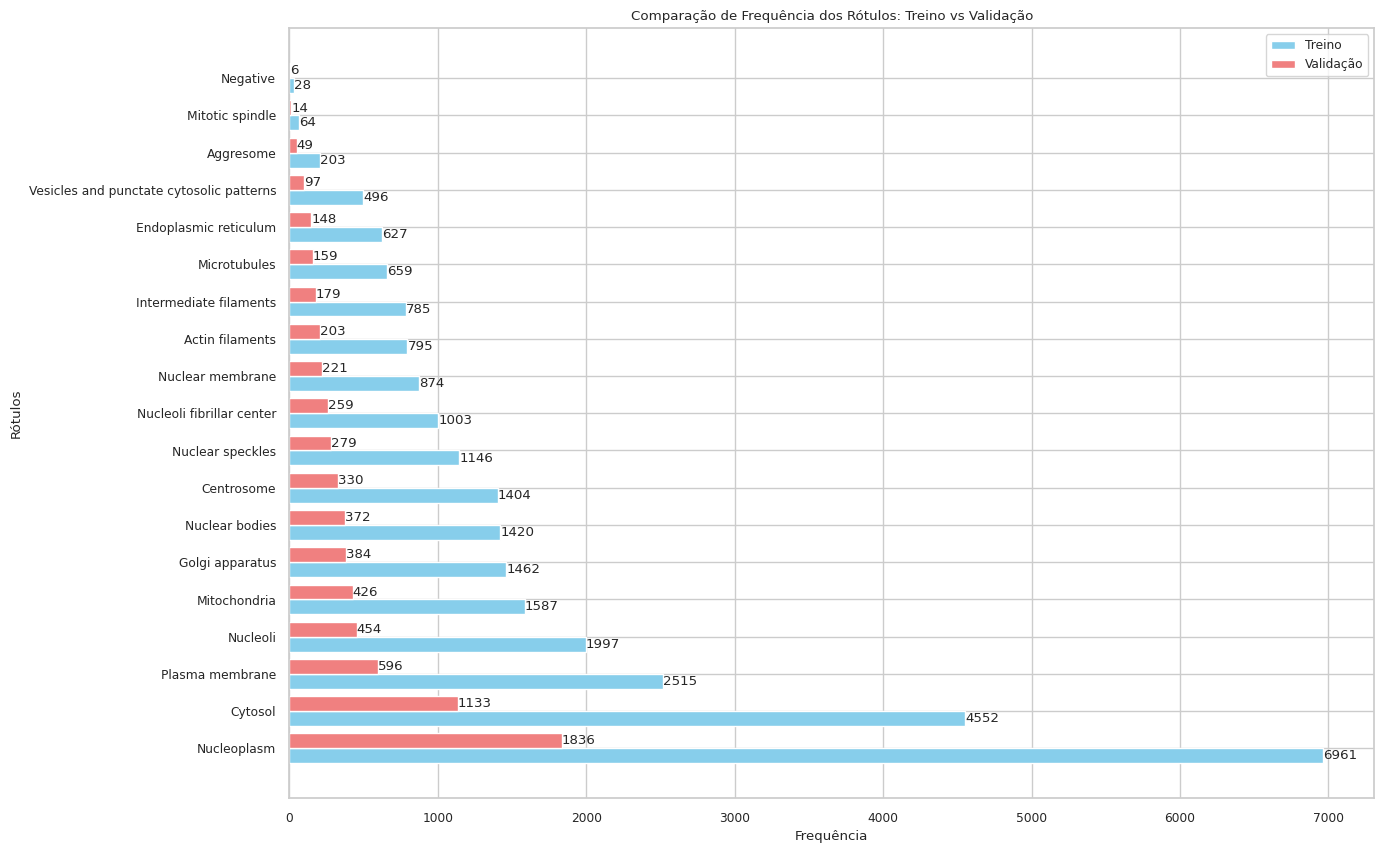

In [24]:
def plot_label_distribution(train_dataset, valid_dataset, classes_map):
    def get_label_counts(dataset):
        label_counts = dataset.binary_labels.sum(axis=0)
        label_counts_named = {classes_map[i]: count for i, count in enumerate(label_counts)}
        sorted_label_counts_named = dict(sorted(label_counts_named.items(), key=lambda item: item[1], reverse=True))
        return sorted_label_counts_named

    # Obter a distribuição dos rótulos nos conjuntos de treino e validação
    train_label_counts = get_label_counts(train_dataset)
    valid_label_counts = get_label_counts(valid_dataset)

    # Preparar os dados para o gráfico
    labels = list(train_label_counts.keys())
    train_counts = list(train_label_counts.values())
    valid_counts = [valid_label_counts.get(label, 0) for label in labels]  # 0 para labels que não estão no conjunto de validação

    # Plotar os gráficos de barras
    x = range(len(labels))
    width = 0.4

    plt.figure(figsize=(14, 10))
    plt.barh([i - width/2 for i in x], train_counts, height=width, label='Treino', color='skyblue')
    plt.barh([i + width/2 for i in x], valid_counts, height=width, label='Validação', color='lightcoral')
    plt.xlabel('Frequência')
    plt.ylabel('Rótulos')
    plt.title('Comparação de Frequência dos Rótulos: Treino vs Validação')
    plt.yticks(x, labels)
    plt.legend()

    # Adicionar as quantidades ao lado das barras
    for i, (train_count, valid_count) in enumerate(zip(train_counts, valid_counts)):
        plt.text(train_count, i - width/2, f'{int(train_count)}', va='center')
        plt.text(valid_count, i + width/2, f'{int(valid_count)}', va='center')

    plt.show()

# Exemplo de uso:
plot_label_distribution(train, valid, classes_map)

### Treinar

In [25]:
# EFFICIENTNET B0
# Congelar todas as camadas
# for param in model.parameters():
#     param.requires_grad = False

# Descongelar a última camada para fine-tuning
# for param in model.classifier[1].parameters():
#     param.requires_grad = True

# Descongelar a primeira camada convolucional
# for param in model.features[0].parameters():
#     param.requires_grad = True

In [26]:
# Mostra cada classe e o seu peso
for i, weight in enumerate(class_weights):
    print(f"{classes_map[i]}: {weight:.4f}")

Nucleoplasm: 0.2161
Nuclear membrane: 1.7209
Nucleoli: 0.7532
Nucleoli fibrillar center: 1.4996
Nuclear speckles: 1.3125
Nuclear bodies: 1.0592
Endoplasmic reticulum: 2.3989
Golgi apparatus: 1.0288
Intermediate filaments: 1.9161
Actin filaments: 1.8920
Microtubules: 2.2824
Mitotic spindle: 23.5016
Centrosome: 1.0713
Plasma membrane: 0.5981
Mitochondria: 0.9478
Aggresome: 7.4094
Cytosol: 0.3304
Vesicles and punctate cytosolic patterns: 3.0325
Negative: 53.7180


In [51]:
num_epochs = 15
learning_rate = 0.0005

checkpoint = '/mnt/ssd/hpa-single-cell-image-classification/checkpoint_15.pth'
resume_checkpoint = '/mnt/ssd/hpa-single-cell-image-classification/checkpoint_5.pth'

# SqueezeNet
# Congelar todas as camadas por padrão
for param in model.parameters():
    param.requires_grad = False

# Descongelar a primeira camada (features[0]) e a última camada (classifier)
for param in model.squeezenet.features[0].parameters():
    param.requires_grad = True

for param in model.squeezenet.classifier.parameters():
    param.requires_grad = True

# Definir o otimizador apenas para os parâmetros descongelados
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate
)

# Definir a função de perda (criterion)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Quantos batches para atualizar os pesos
weight_update = 4

train_squeeze_cam(
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    model,
    num_epochs,
    checkpoint,
    weight_update,
    resume_checkpoint)

/tmp/ipykernel_5903/224698976.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)
Epoch 4/15:   0%|          | 0/1091 [00:00<?, ?batch/s]

Validation: 100%|██████████| 273/273 [05:55<00:00,  1.30s/batch, Valid Loss=3.47]


Epoch 4/15 - Train Loss: 3.4385 - Valid Loss: 3.4740


Validation: 100%|██████████| 273/273 [05:45<00:00,  1.26s/batch, Valid Loss=3.35]


Epoch 5/15 - Train Loss: 3.3522 - Valid Loss: 3.3543


Validation: 100%|██████████| 273/273 [05:56<00:00,  1.31s/batch, Valid Loss=3.39]


Epoch 6/15 - Train Loss: 3.2718 - Valid Loss: 3.3925


Validation: 100%|██████████| 273/273 [05:50<00:00,  1.28s/batch, Valid Loss=3.31]


Epoch 7/15 - Train Loss: 3.2106 - Valid Loss: 3.3127


Validation: 100%|██████████| 273/273 [06:01<00:00,  1.32s/batch, Valid Loss=3.32]


Epoch 8/15 - Train Loss: 3.1442 - Valid Loss: 3.3198


Validation: 100%|██████████| 273/273 [06:03<00:00,  1.33s/batch, Valid Loss=3.31]


Epoch 9/15 - Train Loss: 3.1014 - Valid Loss: 3.3062


Validation: 100%|██████████| 273/273 [06:07<00:00,  1.35s/batch, Valid Loss=3.26]


Epoch 10/15 - Train Loss: 3.0406 - Valid Loss: 3.2568


Validation: 100%|██████████| 273/273 [05:53<00:00,  1.30s/batch, Valid Loss=3.24]


Epoch 11/15 - Train Loss: 2.9911 - Valid Loss: 3.2440


Validation: 100%|██████████| 273/273 [06:07<00:00,  1.35s/batch, Valid Loss=3.25]


Epoch 12/15 - Train Loss: 2.9498 - Valid Loss: 3.2488


Validation: 100%|██████████| 273/273 [06:03<00:00,  1.33s/batch, Valid Loss=3.21]


Epoch 13/15 - Train Loss: 2.9393 - Valid Loss: 3.2092


Validation: 100%|██████████| 273/273 [06:11<00:00,  1.36s/batch, Valid Loss=3.2] 


Epoch 14/15 - Train Loss: 2.8950 - Valid Loss: 3.2005


Validation: 100%|██████████| 273/273 [06:04<00:00,  1.33s/batch, Valid Loss=3.23]

Epoch 15/15 - Train Loss: 2.8644 - Valid Loss: 3.2297


In [52]:
# Salvar o modelo
torch.save(model, '/mnt/ssd/hpa-single-cell-image-classification/squeezenet_15.pth')

In [36]:
# Acurácia por classe
def class_accuracy(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    class_correct = torch.zeros(19)
    class_total = torch.zeros(19)
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc='Avaliação', unit='batch')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            _, _, outputs = model(inputs)
            predicted = outputs > 0.5
            correct = predicted == labels
            for i in range(19):
                class_correct[i] += correct[:, i].sum().item()
                class_total[i] += correct[:, i].shape[0]

    class_accuracy = class_correct / class_total

    return class_accuracy

print(class_accuracy(model, valid_loader))

Avaliação: 100%|██████████| 273/273 [06:35<00:00,  1.45s/batch]

tensor([0.7173, 0.9058, 0.8086, 0.9010, 0.8849, 0.8597, 0.8498, 0.9028, 0.9149,
        0.8987, 0.9415, 0.9264, 0.8012, 0.8698, 0.9097, 0.9583, 0.7634, 0.9436,
        0.8650])


In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Inicializar contadores para todas as imagens
num_classes = 19
tp = np.zeros(num_classes)  # Verdadeiros Positivos
fp = np.zeros(num_classes)  # Falsos Positivos
tn = np.zeros(num_classes)  # Verdadeiros Negativos
fn = np.zeros(num_classes)  # Falsos Negativos

# Loop por todas as imagens no conjunto de validação
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for image, label in valid:
    image = image.unsqueeze(0).to(device)  # Adicionar dimensão de batch
    _, _, output = model(image)
    predicted = (output > 0.5).cpu().detach().numpy().flatten()  # Previsões
    label = label.numpy().flatten()  # Rótulos reais

    # Calcular os contadores
    for i in range(num_classes):
        if label[i] == 1 and predicted[i] == 1:
            tp[i] += 1
        elif label[i] == 0 and predicted[i] == 1:
            fp[i] += 1
        elif label[i] == 0 and predicted[i] == 0:
            tn[i] += 1
        elif label[i] == 1 and predicted[i] == 0:
            fn[i] += 1

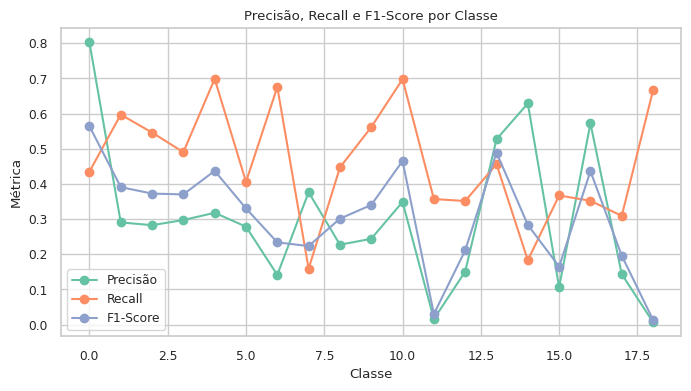

In [49]:
# Printar precisão, recall e f1-score para cada classe
# for i in range(num_classes):
    # precision = tp[i] / (tp[i] + fp[i])
    # recall = tp[i] / (tp[i] + fn[i])
    # f1_score = 2 * (precision * recall) / (precision + recall)
    # print(f"Classe {i}: Precisão = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1_score:.4f}")

# Plotar precisão, recall e f1-score para cada classe num gráfico bonitinho
classes = list(range(num_classes))
precisions = [tp[i] / (tp[i] + fp[i]) for i in range(num_classes)]
recalls = [tp[i] / (tp[i] + fn[i]) for i in range(num_classes)]
f1_scores = [2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i]) for i in range(num_classes)]

plt.figure(figsize=(8, 4))
plt.plot(classes, precisions, label='Precisão', marker='o')
plt.plot(classes, recalls, label='Recall', marker='o')
plt.plot(classes, f1_scores, label='F1-Score', marker='o')
plt.xlabel('Classe')
plt.ylabel('Métrica')
plt.title('Precisão, Recall e F1-Score por Classe')
plt.legend()
plt.show()

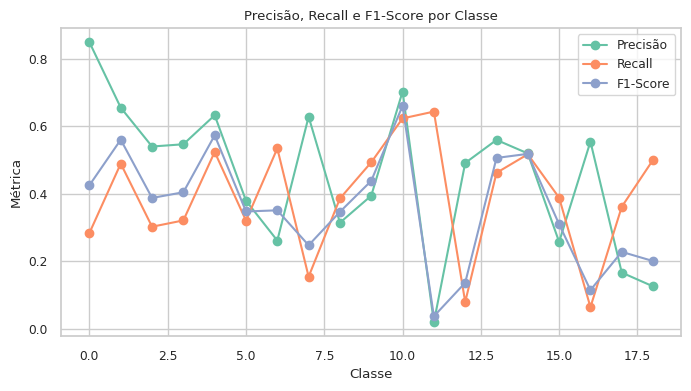

In [54]:
# Printar precisão, recall e f1-score para cada classe
# for i in range(num_classes):
    # precision = tp[i] / (tp[i] + fp[i])
    # recall = tp[i] / (tp[i] + fn[i])
    # f1_score = 2 * (precision * recall) / (precision + recall)
    # print(f"Classe {i}: Precisão = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1_score:.4f}")

# Plotar precisão, recall e f1-score para cada classe num gráfico bonitinho
classes = list(range(num_classes))
precisions = [tp[i] / (tp[i] + fp[i]) for i in range(num_classes)]
recalls = [tp[i] / (tp[i] + fn[i]) for i in range(num_classes)]
f1_scores = [2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i]) for i in range(num_classes)]

plt.figure(figsize=(8, 4))
plt.plot(classes, precisions, label='Precisão', marker='o')
plt.plot(classes, recalls, label='Recall', marker='o')
plt.plot(classes, f1_scores, label='F1-Score', marker='o')
plt.xlabel('Classe')
plt.ylabel('Métrica')
plt.title('Precisão, Recall e F1-Score por Classe')
plt.legend()
plt.show()

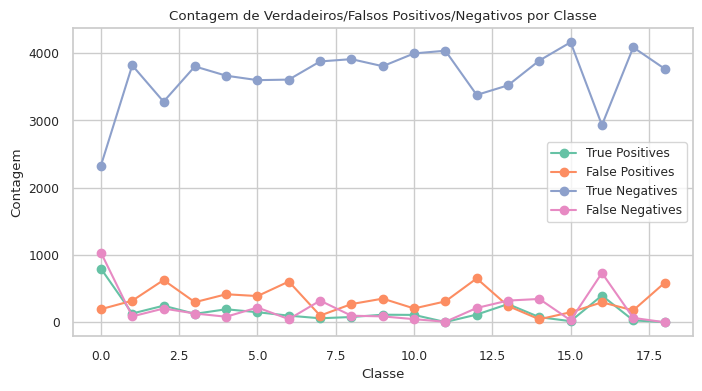

In [47]:
# Plotar num gráfico bonitinho
plt.figure(figsize=(8, 4))
plt.plot(range(num_classes), [tp[i] for i in range(num_classes)], label='True Positives', marker='o')
plt.plot(range(num_classes), [fp[i] for i in range(num_classes)], label='False Positives', marker='o')
plt.plot(range(num_classes), [tn[i] for i in range(num_classes)], label='True Negatives', marker='o')
plt.plot(range(num_classes), [fn[i] for i in range(num_classes)], label='False Negatives', marker='o')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.title('Contagem de Verdadeiros/Falsos Positivos/Negativos por Classe')
plt.legend()
plt.show()

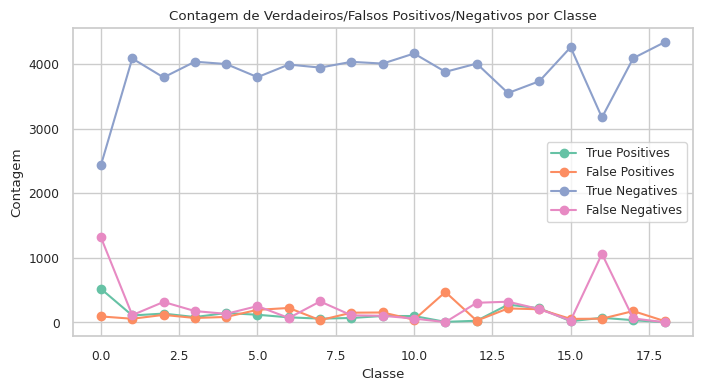

In [55]:
# Plotar num gráfico bonitinho
plt.figure(figsize=(8, 4))
plt.plot(range(num_classes), [tp[i] for i in range(num_classes)], label='True Positives', marker='o')
plt.plot(range(num_classes), [fp[i] for i in range(num_classes)], label='False Positives', marker='o')
plt.plot(range(num_classes), [tn[i] for i in range(num_classes)], label='True Negatives', marker='o')
plt.plot(range(num_classes), [fn[i] for i in range(num_classes)], label='False Negatives', marker='o')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.title('Contagem de Verdadeiros/Falsos Positivos/Negativos por Classe')
plt.legend()
plt.show()

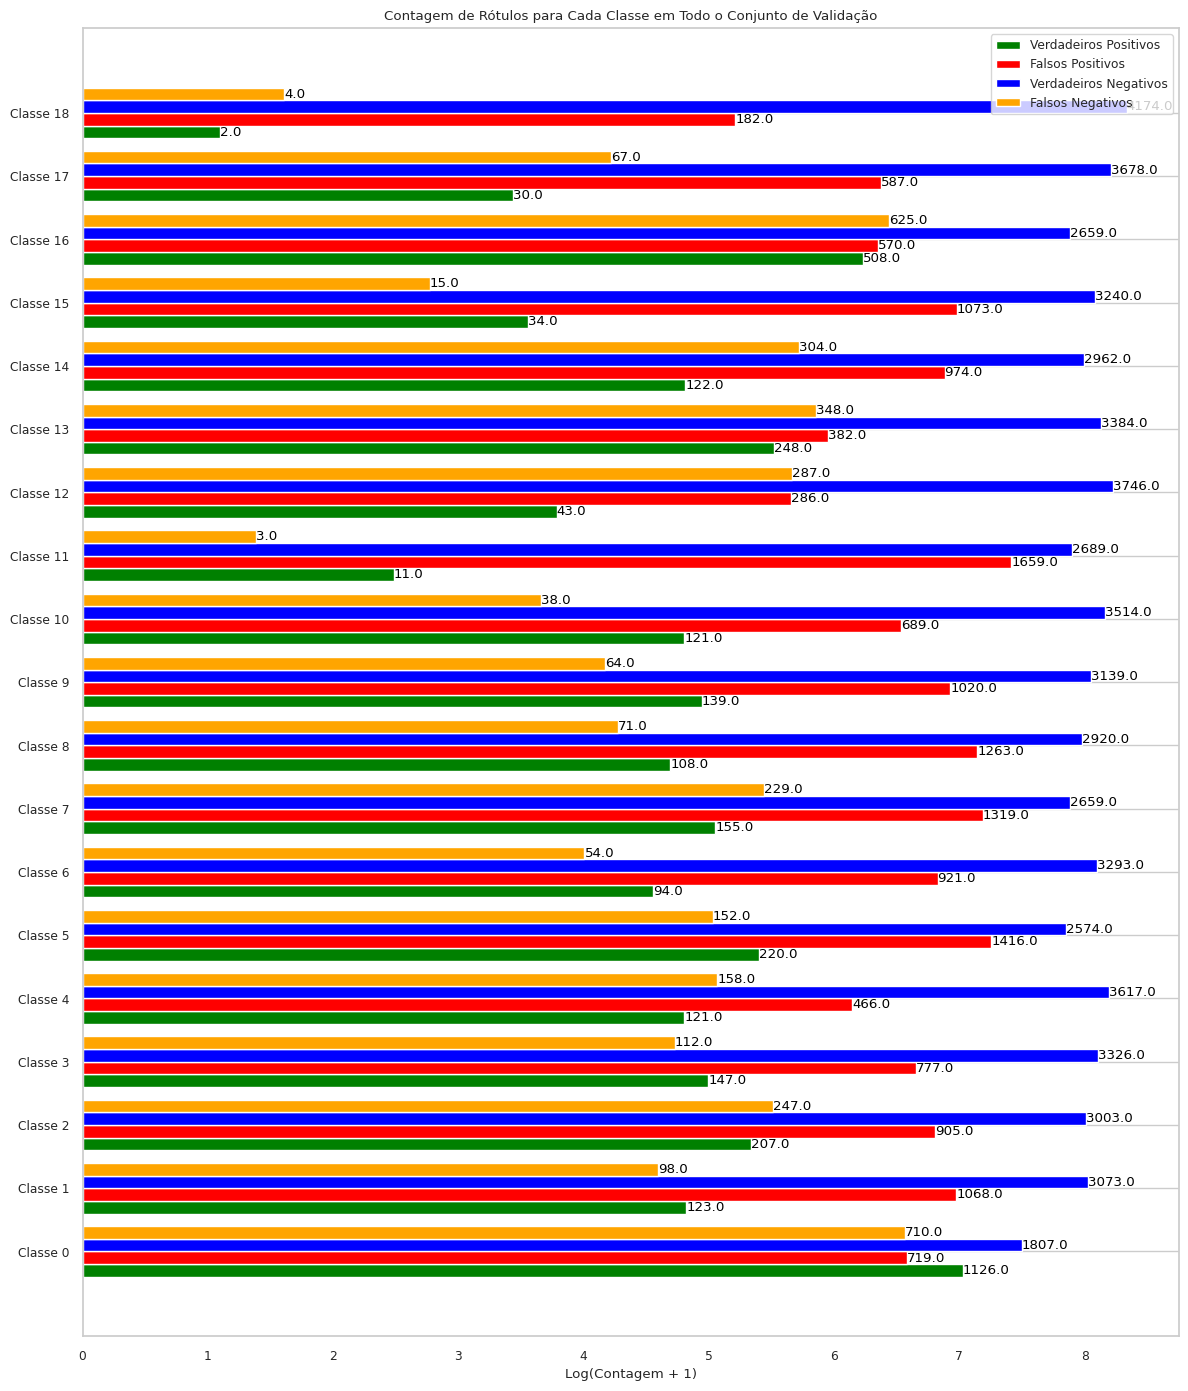

In [34]:
# Dados para o gráfico
labels = [f'Classe {i}' for i in range(num_classes)]
bar_width = 0.2
x = np.arange(num_classes)

# Aplicar transformação logarítmica para visualização
tp_log = np.log1p(tp)  # log(1 + x) para evitar log(0)
fp_log = np.log1p(fp)
tn_log = np.log1p(tn)
fn_log = np.log1p(fn)

# Criar gráfico horizontal
plt.figure(figsize=(12, 14))
plt.barh(x - 1.5 * bar_width, tp_log, height=bar_width, label='Verdadeiros Positivos', color='green')
plt.barh(x - 0.5 * bar_width, fp_log, height=bar_width, label='Falsos Positivos', color='red')
plt.barh(x + 0.5 * bar_width, tn_log, height=bar_width, label='Verdadeiros Negativos', color='blue')
plt.barh(x + 1.5 * bar_width, fn_log, height=bar_width, label='Falsos Negativos', color='orange')

# Adicionar os números em cima das barras
for i in range(num_classes):
    plt.text(tp_log[i], i - 1.5 * bar_width, f'{tp[i]}', va='center', ha='left', color='black')
    plt.text(fp_log[i], i - 0.5 * bar_width, f'{fp[i]}', va='center', ha='left', color='black')
    plt.text(tn_log[i], i + 0.5 * bar_width, f'{tn[i]}', va='center', ha='left', color='black')
    plt.text(fn_log[i], i + 1.5 * bar_width, f'{fn[i]}', va='center', ha='left', color='black')

# Configurações do gráfico
plt.xlabel('Log(Contagem + 1)')
plt.title('Contagem de Rótulos para Cada Classe em Todo o Conjunto de Validação')
plt.yticks(x, labels)
plt.legend()
plt.grid(axis='x')
plt.tight_layout()

# Exibir gráfico
plt.show()

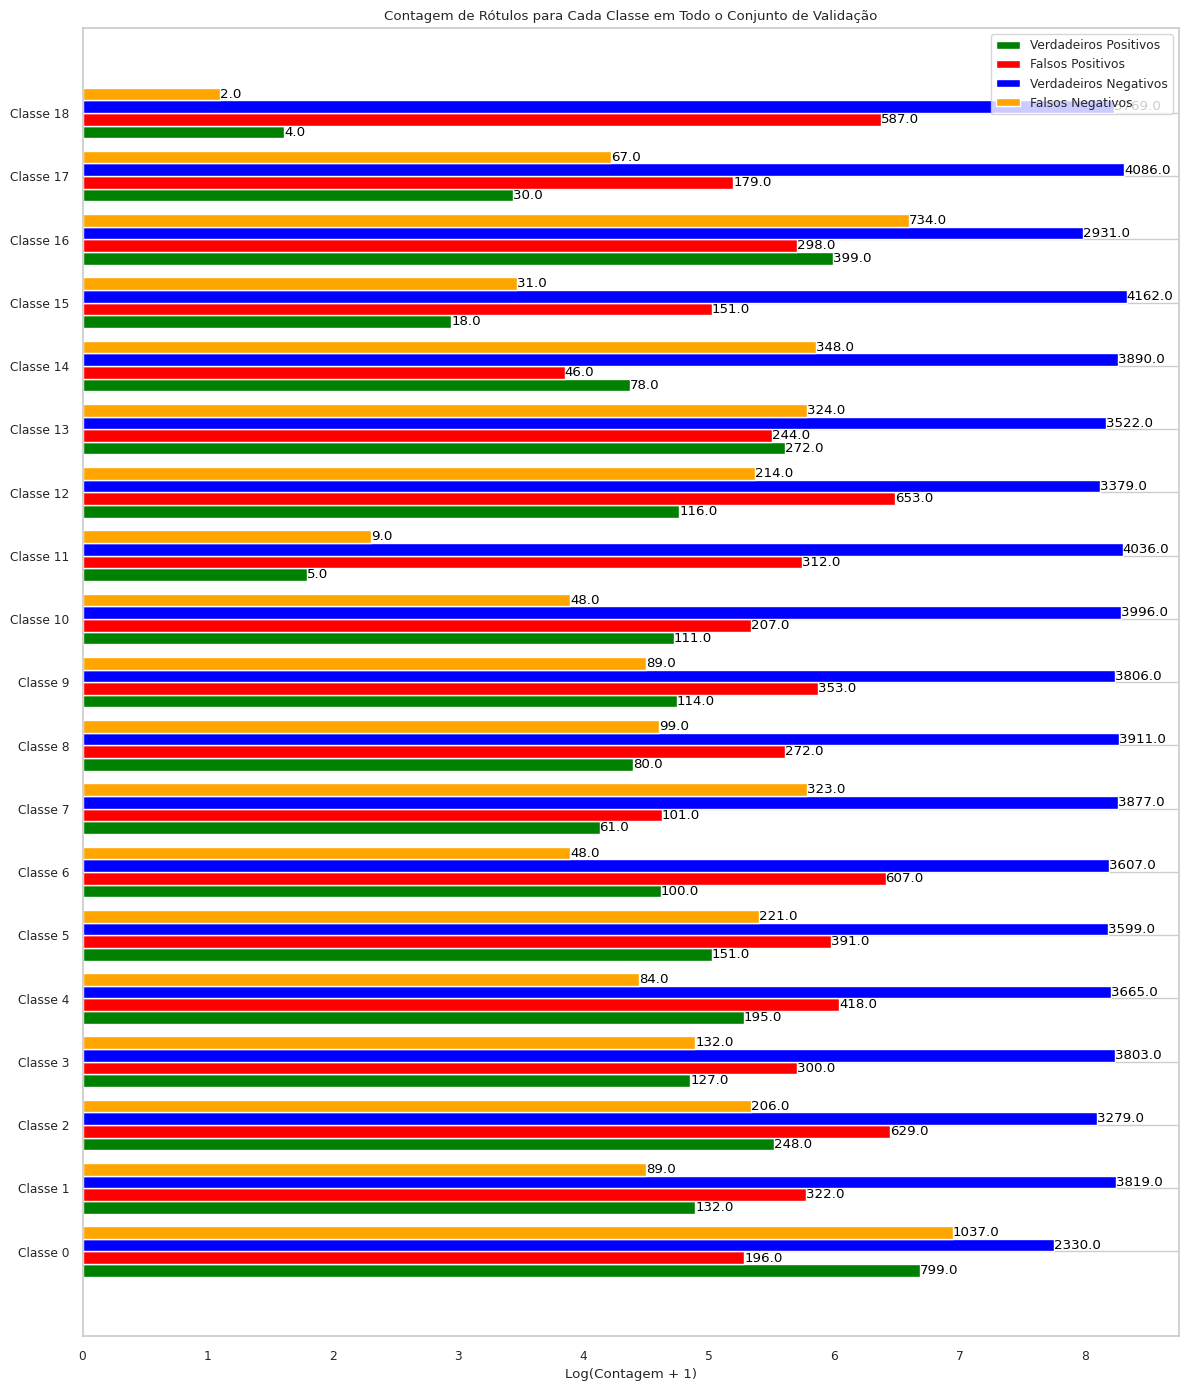

In [39]:
# Dados para o gráfico
labels = [f'Classe {i}' for i in range(num_classes)]
bar_width = 0.2
x = np.arange(num_classes)

# Aplicar transformação logarítmica para visualização
tp_log = np.log1p(tp)  # log(1 + x) para evitar log(0)
fp_log = np.log1p(fp)
tn_log = np.log1p(tn)
fn_log = np.log1p(fn)

# Criar gráfico horizontal
plt.figure(figsize=(12, 14))
plt.barh(x - 1.5 * bar_width, tp_log, height=bar_width, label='Verdadeiros Positivos', color='green')
plt.barh(x - 0.5 * bar_width, fp_log, height=bar_width, label='Falsos Positivos', color='red')
plt.barh(x + 0.5 * bar_width, tn_log, height=bar_width, label='Verdadeiros Negativos', color='blue')
plt.barh(x + 1.5 * bar_width, fn_log, height=bar_width, label='Falsos Negativos', color='orange')

# Adicionar os números em cima das barras
for i in range(num_classes):
    plt.text(tp_log[i], i - 1.5 * bar_width, f'{tp[i]}', va='center', ha='left', color='black')
    plt.text(fp_log[i], i - 0.5 * bar_width, f'{fp[i]}', va='center', ha='left', color='black')
    plt.text(tn_log[i], i + 0.5 * bar_width, f'{tn[i]}', va='center', ha='left', color='black')
    plt.text(fn_log[i], i + 1.5 * bar_width, f'{fn[i]}', va='center', ha='left', color='black')

# Configurações do gráfico
plt.xlabel('Log(Contagem + 1)')
plt.title('Contagem de Rótulos para Cada Classe em Todo o Conjunto de Validação')
plt.yticks(x, labels)
plt.legend()
plt.grid(axis='x')
plt.tight_layout()

# Exibir gráfico
plt.show()

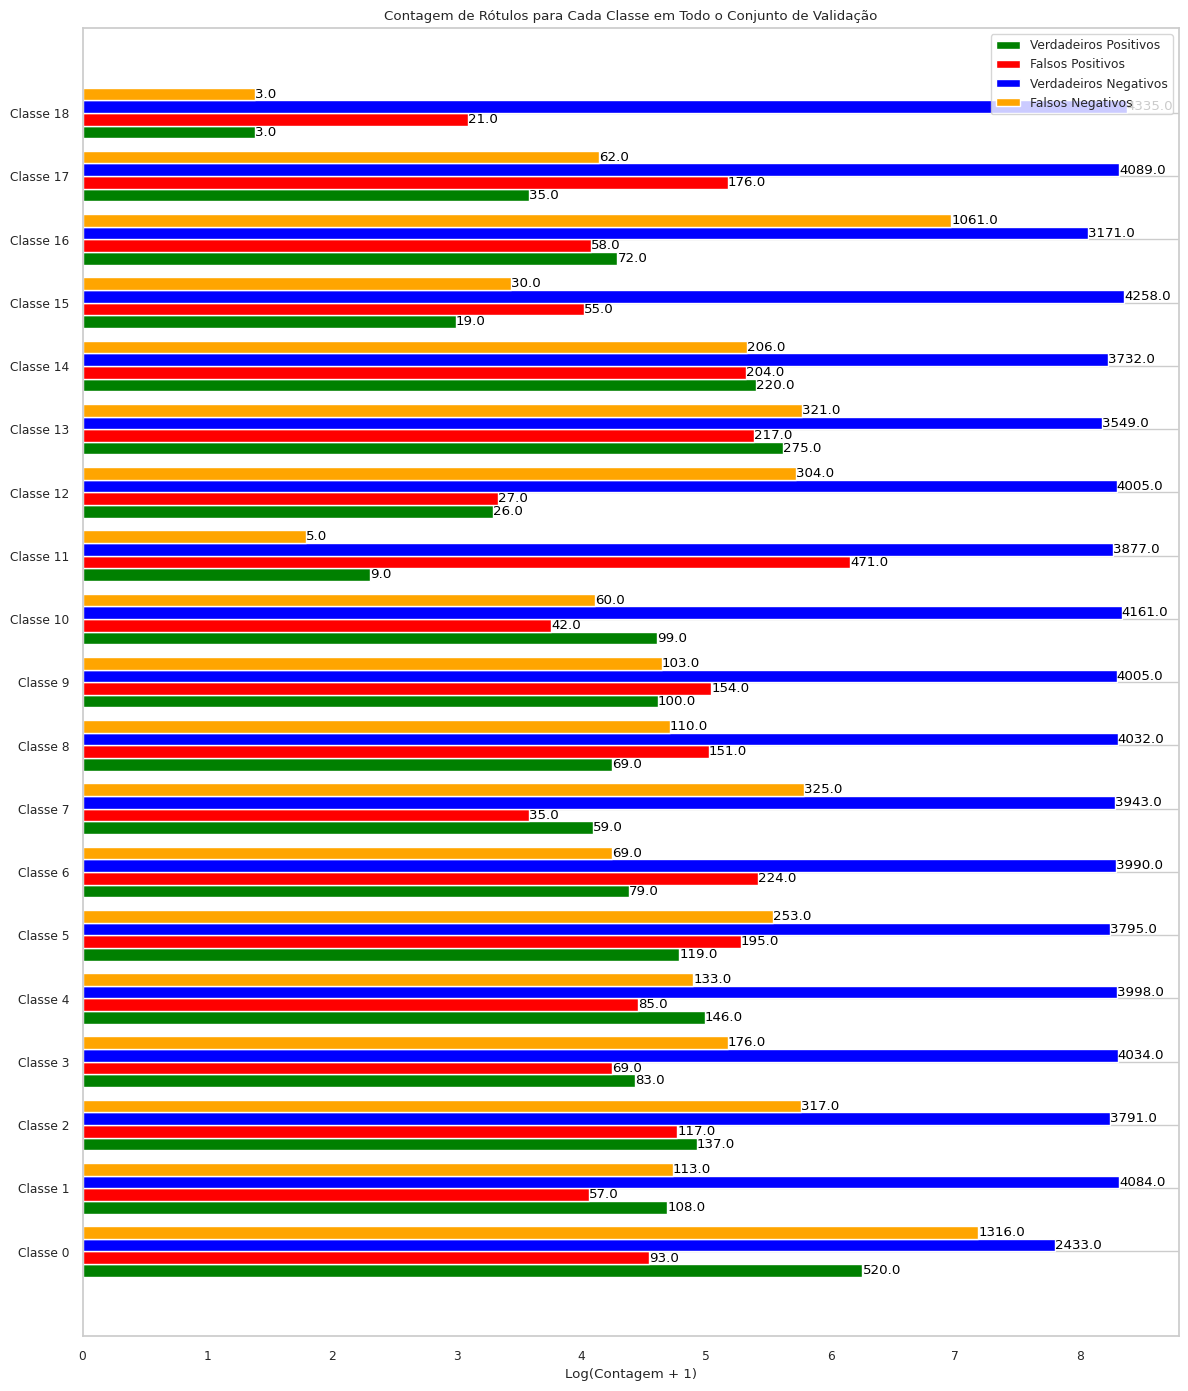

In [56]:
# Dados para o gráfico
labels = [f'Classe {i}' for i in range(num_classes)]
bar_width = 0.2
x = np.arange(num_classes)

# Aplicar transformação logarítmica para visualização
tp_log = np.log1p(tp)  # log(1 + x) para evitar log(0)
fp_log = np.log1p(fp)
tn_log = np.log1p(tn)
fn_log = np.log1p(fn)

# Criar gráfico horizontal
plt.figure(figsize=(12, 14))
plt.barh(x - 1.5 * bar_width, tp_log, height=bar_width, label='Verdadeiros Positivos', color='green')
plt.barh(x - 0.5 * bar_width, fp_log, height=bar_width, label='Falsos Positivos', color='red')
plt.barh(x + 0.5 * bar_width, tn_log, height=bar_width, label='Verdadeiros Negativos', color='blue')
plt.barh(x + 1.5 * bar_width, fn_log, height=bar_width, label='Falsos Negativos', color='orange')

# Adicionar os números em cima das barras
for i in range(num_classes):
    plt.text(tp_log[i], i - 1.5 * bar_width, f'{tp[i]}', va='center', ha='left', color='black')
    plt.text(fp_log[i], i - 0.5 * bar_width, f'{fp[i]}', va='center', ha='left', color='black')
    plt.text(tn_log[i], i + 0.5 * bar_width, f'{tn[i]}', va='center', ha='left', color='black')
    plt.text(fn_log[i], i + 1.5 * bar_width, f'{fn[i]}', va='center', ha='left', color='black')

# Configurações do gráfico
plt.xlabel('Log(Contagem + 1)')
plt.title('Contagem de Rótulos para Cada Classe em Todo o Conjunto de Validação')
plt.yticks(x, labels)
plt.legend()
plt.grid(axis='x')
plt.tight_layout()

# Exibir gráfico
plt.show()